## Statistical Methods in Python For Rare Event Searches

*Summer Course at Canfranc Underground Laboratory (LSC) July 2019*

## Hypothesis test and regression - practical example

*Author: Jose A. Hernando*, June 2019

*Instituto Galego de Altas Enerxías. Universidade de Santiago de Compostela, Spain.*

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize

# possible styles: ggplot (simplicity), bmh (scientify data), 
plt.style.context('seaborn-colorblind')

import htcore    as htcore
import htcatalog as htcata
import httoys    as httoys
import htplot    as htplot

# ploting images
from IPython.display import display, Image

In [2]:
import time

print(' Last Execution ', time.asctime())

 Last Execution  Thu Jul 11 10:18:59 2019


----

## Practical example - hypothesis testing - CI a la Feldman-Cousins

**Example** Consider an experiment that measures an exponential spectrum and an a gaussian peak. The gaussian peak is our alternative hypothesis. Given an observation data compute the CI a la FC a 90% CL.


First we generate an observation, $x_0$, with a blind number of events in the gaussian peak.

The number of events in the gaussian peak is our paremter of interest $\mu$

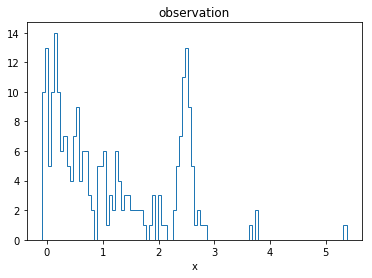

In [3]:
import blind
nu_peak, nub, tau, peak_mu, peak_sigma = blind.nupeak_1, 200., -0.1, 2.5, 0.1
par = [nu_peak, nub, tau, peak_mu, peak_sigma]
rv  = htcata.extended_norm_expon
x0 = rv.rvs(*par, size = 1)[0]
#xs = np.concatenate(xs); x0 = xs.flatten() # add several datasets
plt.hist(x0, 100, histtype = 'step'); plt.xlabel('x'); plt.title('observation');

Next, we compute the best estimate of the number of events in the gaussian peak, using MLE. 

We assume that we know all the other parameters but the number of events in the peak. We will see later how proceed if we do not know the other parameters.

In [4]:
mask = (True, False, False, False, False) # Fit only the nu-peak
ht = htcore.htcomposite(rv, par, mask = mask)
parbest0 = ht.parbest(x0)
muhat0   = parbest0[0]
print('mu-hat(x0) :', muhat0)

mu-hat(x0) : 47.78648376464844


We scan along $\mu$ and compute for $\mu$ the value

$$
t_\mu(x_0) = - 2 \ln \frac{\mathcal{L}(x_0 | \mu)}{\mathcal{L}(x_0 | \hat{\mu}(x_0)}
$$

In in order words:

$$
t_\mu(x_0) = - 2 \ln \mathcal{L}(x_0| \mu) + 2 \ln \mathcal{L}(x_0 |\hat{\mu}(x_0))  = - 2 \Delta \ln \mathcal{L}
$$

In [5]:
def plt_llscan(ht, x0, mu0, beta, mul, mup, nbins):
    mus   = np.linspace(mul, mup, nbins)
    tmu0s = [ht.tmu(x0, mui, mu0 = mu0) for mui in mus]
    plt.plot(mus, tmu0s, label = r'$t_\mu(x_0)$'); 
    plt.plot(mus, 1.*np.ones(nbins));
    plt.xlabel(r'$\mu$'); plt.ylabel(r'$-2 \Delta \ln \mathcal{L} = t_\mu(x_0)$');
    plt.grid(); plt.legend();
    ci = ht.tmu_cint(x0, parbest = parbest0, beta = beta)
    htplot.prt_wilks_pvalues(beta, ci_central = ci)
    return ci

central CI  : [40.76967234 55.47193667] at  68 % CL


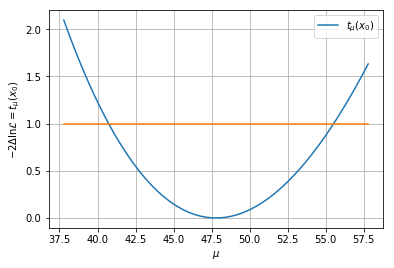

In [6]:
mu0, mul, mup, nbins, beta  = 0., muhat0 - 10, muhat0 + 10, 50, 0.68
ci = plt_llscan(ht, x0, mu0, beta, mul, mup, nbins)

In [7]:
def tmus_rvs(ht, par, mu, mu0 = None, size = 100):
    print(' generating', size, ' events with mu ', mu, 'and mu0 ', mu0)
    parmu    = np.array(par);
    par[0]   = mu
    xs       = ht.rvs(*par, size = size)
    mubests  = np.array([ht.mubest(xi, mu0 = mu0)[0] for xi in xs]) 
    tmus     = np.array([ht.tmu(xi, mu, mu0 = mu0) for xi in xs])
    sel      = tmus >= 0.
    return tmus[sel], mubests[sel]

def plt_tmus(tmus, tmu0 = None, mu = None):
    if (tmu0 is not None) and (mu is not None):
        print(' tmu ', tmu0, ' of x0 at mu ', mu)
    ys, xs, _ = plt.hist(tmus, 100, histtype = 'step', density = True);
    if (tmu0 is None): return
    xs = 0.5*(xs[1:] + xs[:-1]) 
    plt.yscale('log'); plt.xlabel(r'$t_\mu$');
    sel = (xs >= tmu0)
    print(' p-value :', 1.*np.sum([tmus >= tmu0])/(1.*size))
    plt.fill_between(xs[sel], ys[sel], color = 'red', alpha = 0.5);
    return

def plt_muhats(muhats):
    plt.hist(muhats, 100, histtype = 'step'); #plt.yscale('log');
    plt.xlabel(r'$\hat{\mu}$')
    return

In [8]:
def plt_mu_segment(ht, par, x0, mu, mu0, size):
    tmus, muhats = tmus_rvs(ht, par, mu, mu0 = mu0, size = 500)
    tmu0 = ht.tmu(x0, mu = mu, mu0 = mu0)
    plt.subplot(2, 1, 1)
    plt_tmus(tmus, tmu0, mu)
    plt.subplot(2, 1, 2)
    plt_muhats(muhats);

Now, we are going to scan along the mu parameters to define the CL.

Let's start from a $\mu$ close to $\hat{\mu}(x_0)$.

We are going to obtaine the pdf, $g(t_\mu, \mu)$, of the FC variable, $t_\mu$. 
For that we are going to simulate a large number of experiments with $\mu$, for each one we compute $t_\mu(x)$.

Remember that:

$$
t_\mu(x) = -2 \ln \frac{\mathcal{L}(x | \mu)}{\mathcal{L}(x | \hat{\mu}(x)}
$$

muhat  53.02589416503906 tmu  0.4874805056357445  at mu  47.78648376464844


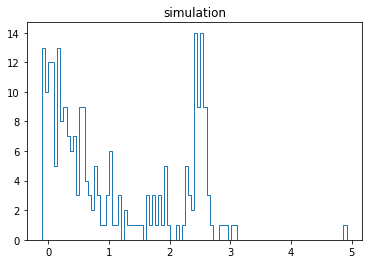

In [9]:
mu       = muhat0 
parmu    = np.array(par)
parmu[0] = mu
xi = rv.rvs(*parmu, size = 1)[0]
plt.hist(xi, 100, histtype = 'step'); plt.title('simulation');
muhat = ht.mubest(xi, mu)[0]
tmu   = ht.tmu(xi, mu)
print('muhat ', muhat, 'tmu ', tmu, ' at mu ', mu)

Now we compute $t_\mu(x_0)$ for the observed data and where in the $t_\mu$ distribution is our observation.

From there we can compute the p-value as the fraction of events with equal or worse $t_\mu$ than the $t_\mu$ of our observed data for this $\mu$.

 generating 500  events with mu  47.78648376464844 and mu0  0.0
 tmu  0.0  of x0 at mu  47.78648376464844
 p-value : 1.0


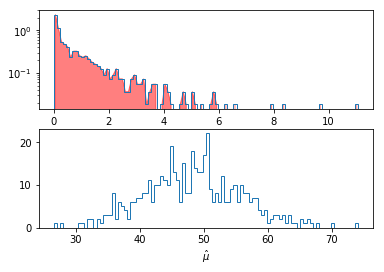

In [10]:
mu, mu0, size = muhat0, 0., 500
plt_mu_segment(ht, par, x0, mu, mu0, size)

We scan along $\mu$, let's consider a low $\mu_l$ value and obtain the pdf of $g(t_\mu | \mu_l)$

 generating 500  events with mu  40.7696723446677 and mu0  0.0
 tmu  0.9889464814779672  of x0 at mu  40.7696723446677
 p-value : 0.3


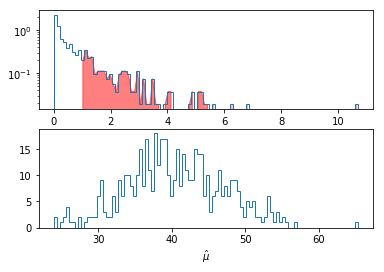

In [11]:
mu = muhat0 - 10
mu = ci[0]
plt_mu_segment(ht, par, x0, mu, mu0, size)

We scan along $\mu$, let's consider a high $\mu_u$ value and obtain the pdf of $g(t_\mu | \mu_u)$

 generating 500  events with mu  55.471936671955575 and mu0  0.0
 tmu  0.9889464814780808  of x0 at mu  55.471936671955575
 p-value : 0.328


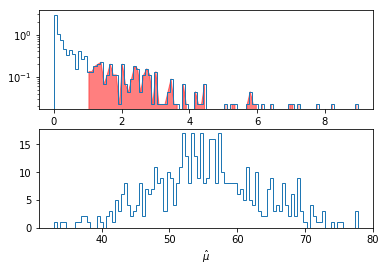

In [12]:
mu = muhat0 + 10
mu = ci[1]
plt_mu_segment(ht, par, x0, mu, mu0, size)

**Exercise**: Check is the case fulfills the Wilk's condition.

 generating 500  events with mu  47.78648376464844 and mu0  0.0
chi2  0.9963715974397576
p-value mean : 0.49424152755123135 ; std * sqrt(12.) : 0.9937187726313097


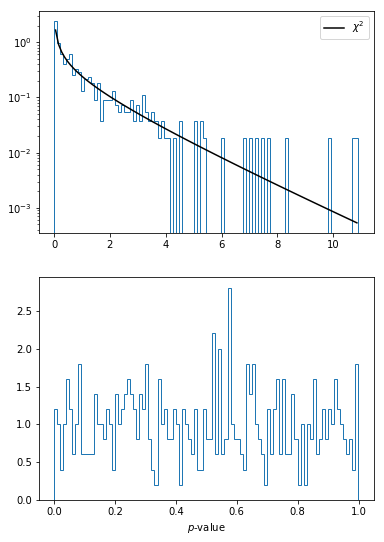

In [13]:
tmus, muhats = tmus_rvs(ht, par, mu = muhat0, mu0 = mu0, size = size)
htplot.chi2_test(tmus);

**Exercise**: Compute the CI at 68 % CL using $t_\mu(x)$ and the p0-value for the case $\nu_g = 0$.

In [14]:
def plt_pvalues(ht, x0, mu0, mul, mup, nbins, beta):
    q0 = ht.q0(x0, 0., parbest = parbest0)
    p0 = htcore.q0_pvalue(q0)
    mus   = np.linspace(max(0., muhat0 - 20), muhat0 + 20, 100)
    tmus  = [ht.tmu(x0, mui, mu0 = mu0, parbest = parbest0) for mui  in mus]
    ptmus = [htcore.tmu_pvalue(tmui)             for tmui in tmus]
    htplot.plt_wilks_pvalues(beta, mus, ptmus);
    ci = ht.tmu_cint(x0, parbest = parbest0, beta = beta)
    htplot.prt_wilks_pvalues(beta, ci_central = ci, p0 = p0)

central CI  : [40.76967234 55.47193667] at  68 % CL
p0 value    : 0.0


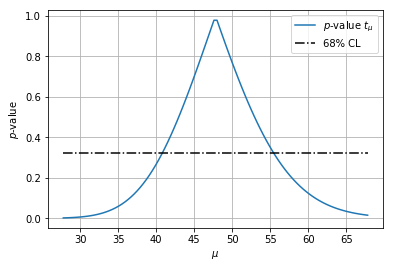

In [15]:
beta = 0.68
plt_pvalues(ht, x0, mu0, mul, mup, nbins, beta)

### Example: signal & control region

bkg events : 33 signal events : 6


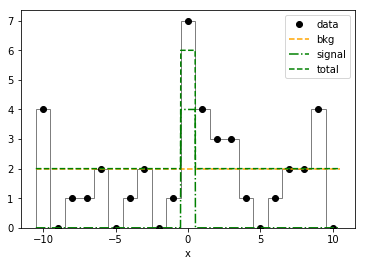

In [16]:
mu, nu, tau = blind.mu, 2., 20.
httoys.poisson_control_rvs(mu, nu, tau, tau + 1);

In [18]:
mu0        = 0.
par, mask, masknu  = [mu, nu, tau], [True, True, False], [False, True, False]

rv       = htcata.poisson_control_signal
x0       = rv.rvs(*par, size =1)[0]
ht       = htcore.htcomposite(rv, par, mask = mask, masknu = masknu) 
parbest0 = ht.parbest(x0, mu0 = mu0)
muhat0   = parbest0[0]

print('events in control, signal region :', x0[0], x0[1])
print('events in control region/tau     :', x0[0]/tau)
print('parbest(x0) :', parbest0)
print('muhat(x0)   :', muhat0)

events in control, signal region : 38.0 3.0
events in control region/tau     : 1.9
parbest(x0) : [ 1.10003689  1.90000098 20.        ]
muhat(x0)   : 1.100036890186684


central CI  : [-0.35197758  3.18577853] at  68 % CL


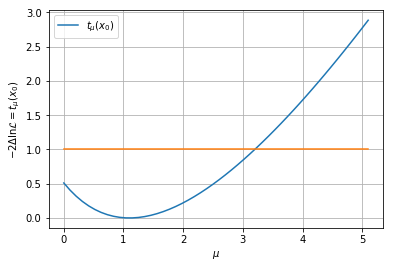

In [19]:
mu0, mul, mup, nbins, beta  = 0., max(0., muhat0 - 4), muhat0 + 4, 50, 0.68
ci = plt_llscan(ht, x0, mu0, beta, mul, mup, nbins)

 generating 500  events with mu  0.0 and mu0  0.0
 tmu  0.5104995190769444  of x0 at mu  0.0
 p-value : 0.188


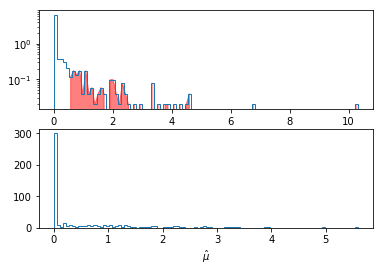

In [21]:
mu = max(mu0, muhat0 + 4.)
mu = max(mu0, ci[0])
plt_mu_segment(ht, par, x0, mu, mu0, size)

 generating 500  events with mu  3.1857785254927684 and mu0  0.0
 tmu  0.9889464814780169  of x0 at mu  3.1857785254927684
 p-value : 0.342


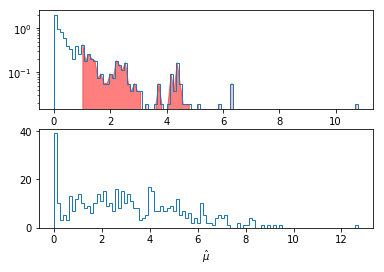

In [22]:
mu = max(mu0, muhat0 - 4.)
mu = ci[1]
plt_mu_segment(ht, par, x0, mu, mu0, size)

 generating 500  events with mu  1.100036890186684 and mu0  0.0
chi2  0.8464536287487783
p-value mean : 0.503349900709909 ; std * sqrt(12.) : 0.9350417537038213


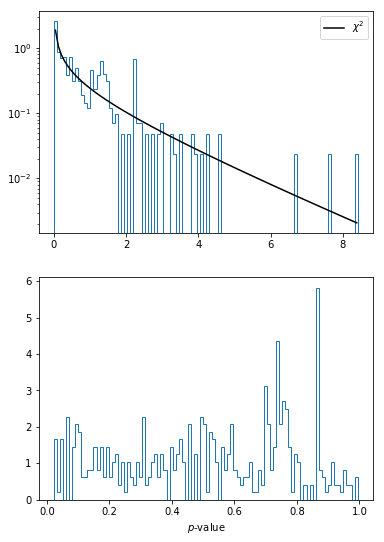

In [23]:
tmus, muhats = tmus_rvs(ht, par, mu = muhat0, mu0 = mu0, size = size)
htplot.chi2_test(tmus);

central CI  : [-0.35197758  3.18577853] at  68 % CL
p0 value    : 0.23746134901223515


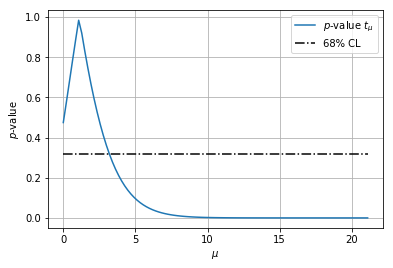

In [24]:
beta = 0.68
plt_pvalues(ht, x0, mu0, mul, mup, nbins, beta)

**Exercise**: Consider now a uniform backgrund $1.3 \times 10^{-4}$ c/(kg y keV) and and two gaussian peaks with sigma 1%, one signal peak, $^{136}$Xe at 4458 keV with unknown number of events and other background peak ($^{214}$Bi) at 4447 keV with 0.06 c/(keV y). Consider the range 2400-2500 keV. 

Compute the upper limit in number of signal events at 90% CL vs exposure in the case there is no signal. 

Compute the observation potential in the case the number of signal is 0.12 c/(keV y).